In [1]:
##libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt

In [21]:
##read data - biomass, Virginia LTER
df = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/Virginia_ChristianBlum.csv', skiprows=21)
df = df[df['speciesName'] == 'Spartina alterniflora'] ##only low marsh and creekbank???
df = df[['EOYBYear', 'collectDate', 'marshName', 'siteName', 'locationID', 'monitoringPurpose', \
         'Transect', 'Replicate', 'speciesName', 'liveMass', 'deadMass', 'totalMass', 'latitude', 'longitude']]
df['collectDate'] = pd.to_datetime(df['collectDate'])
df['liveMass'] = 16 * df['liveMass'] ##look at histograms; is averaging the best way?
df['deadMass'] = 16 * df['deadMass']
df['totalMass'] = 16 * df['totalMass']
locations = [1, 2] ## 1 = creekbank; 2 = low marsh
#df = df[df['locationID'].isin(locations)] ##MOSTLY Spartina alterniflora-only plots; in other zones plots were mixed

##water quality dataset, Virginia LTER
df_wq = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/Virginia_WQ.csv', skiprows=21)
df_wq['measureDate'] = pd.to_datetime(df_wq['measureDate'])

max(df['liveMass'])

#df
##IMPORTANT NOTE: 2017 data does not distinguish live from dead biomass due to a freezer failure

3103.36

In [3]:
##summary statistics
df_means = df.groupby('EOYBYear', as_index = False).mean()
df_sem = df.groupby('EOYBYear').sem()

df_means['Year'] = df_means['EOYBYear']
#df.groupby('EOYBYear').aggregate([np.mean, np.size])
#df_means ##'average lat/long' useless
#df_sem

In [32]:
##grouped by site and by year
mn_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).aggregate([np.mean, np.size, np.std]).reset_index()
se_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).sem()

newdf = df.groupby(['siteName', 'EOYBYear'], as_index = False).mean()

##rearrange lat and long for GEE
mn_siteyears = mn_siteyears[['siteName', 'EOYBYear', 'locationID', 'liveMass', 'longitude', \
                             'latitude', 'deadMass', 'totalMass']]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
    #print(mn_siteyears)

#print(se_siteyears)

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'outx2.csv')
#se_siteyears.to_csv(out_csv, index=False) ##set out directory

newdf['year'] = newdf['EOYBYear']

siteName EOYBYear locationID                   liveMass        \
                                  mean size       std        mean  size   
0       Assateague     2000   1.909091   11  1.136182  177.600000  11.0   
1       Assateague     2001   1.500000   12  0.522233  406.653333  12.0   
2       Assateague     2002   1.400000   10  0.516398  125.840000  10.0   
3          Bellvue     1999   1.625000   16  0.806226  642.700000  16.0   
4          Bellvue     2000   2.375000   16  1.627882  336.100000  16.0   
..             ...      ...        ...  ...       ...         ...   ...   
145        Wallops     2002   1.500000   12  0.522233  306.440000  12.0   
146  Woodland_Farm     1999   1.947368   19  0.779864  191.326316  19.0   
147  Woodland_Farm     2000   1.785714   14  0.801784  752.800000  14.0   
148  Woodland_Farm     2001   3.125000   16  0.806226  408.830000  16.0   
149  Woodland_Farm     2002   1.545455   11  0.687552  184.640000  11.0   

                 longitude              latitude               deadMass        \
            std       mean  size  std       mean  size  std        mean  size   
0    105.157862 -75.372740  11.0  0.0  37.903114  11.0  0.0   70.690909  11.0   
1    211.808363 -75.372740  12.0  0.0  37.903114  12.0  0.0  103.080000  12.0   
2    113.226108 -75.372740  10.0  0.0  37.903114  10.0  0.0  114.656000  10.0   
3    738.508125 -75.671577  16.0  0.0  37.625273  16.0  0.0  174.700000  16.0   
4    365.277568 -75.671577  16.0  0.0  37.625273  16.0  0.0   76.300000  16.0   
..          ...        ...   ...  ...        ...   ...  ...         ...   ...   
145  172.952285 -75.447000  12.0  0.0  37.880000  12.0  0.0  572.906667  12.0   
146  174.714754 -75.819360  19.0  0.0  37.481998  19.0  0.0  476.917895  19.0   
147  366.626870 -75.819360  14.0  0.0  37.481998  14.0  0.0  380.000000  14.0   
148  193.819910 -75.819360  16.0  0.0  37.481998  16.0  0.0  574.010000  16.0   
149  156.002281 -75.819360  11.0  0.0  37.481998  11.0  0.0  711.229091  11.0   

                   totalMass                    
            std         mean  size         std  
0     77.195045   248.290909  11.0  176.484886  
1    137.206357   509.733333  12.0  294.343045  
2     85.070134   240.496000  10.0  186.885030  
3    305.512151   817.400000  16.0  761.278335  
4     76.992467   412.400000  16.0  417.710739  
..          ...          ...   ...         ...  
145  421.585503   879.346667  12.0  384.300455  
146  691.837017   668.244211  19.0  643.547774  
147  219.108572  1132.800000  14.0  428.382345  
148  312.051310   982.840000  16.0  329.514130  
149  777.216178   895.869091  11.0  760.588063  

[150 rows x 20 columns]

In [5]:
##some figures
#df.boxplot(column='liveMass', by='EOYBYear')
#mn_siteyears.boxplot(column='liveMass', by='siteName') ##using averages as individual points

In [23]:
##data analysis with cloud-masked data
#masked_ndvi = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/masked_ndvi.csv')
l5l7l8 = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/L5L7L8_combined.csv')
masked_ndvi = pd.merge(newdf, l5l7l8, on=['year', 'siteName'])   
    
masked_ndvi['EOYBYear'] = pd.to_datetime(masked_ndvi['EOYBYear'], format = '%Y')
masked_ndvi['imagedate'] = pd.to_datetime(masked_ndvi['imagedate'], format = '%m/%d/%y')
masked_ndvi['year'] = pd.DatetimeIndex(pd.to_datetime(round(masked_ndvi['year']), format = '%Y')).year

masked_ndvi['sqrtLive'] = np.sqrt(masked_ndvi['liveMass']) ##in case 'liveMass' does not meet assumptions
xxyrs = [2001, 2003, 2004, 2005, 2006, 2007, 2012, 2013, 2014, 2015, 2016]
masked_ndvi = masked_ndvi[masked_ndvi['year'].isin(xxyrs)] ##filtering out years where high tide -> flooded pixels

masked_ndvi = masked_ndvi[masked_ndvi['ndvi'] > 0] ##Gets rid of obviously flooded pixels and NA values

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
    print(masked_ndvi)

         siteName   EOYBYear  locationID    liveMass    deadMass    totalMass  \
1      Assateague 2001-01-01    1.500000  406.653333  103.080000   509.733333   
4        Box_Tree 2001-01-01    1.500000  953.700000  202.360000  1156.060000   
6        Box_Tree 2004-01-01    2.000000  485.484444  170.782222   656.266667   
7        Box_Tree 2007-01-01    1.875000  374.050000  101.310000   475.360000   
10       Box_Tree 2012-01-01    1.461538  510.449231   98.855385   609.304615   
11       Box_Tree 2013-01-01    1.714286  396.971429    0.000000   396.971429   
12       Box_Tree 2016-01-01    1.692308  406.941538    0.000000   406.941538   
14  Channel_Point 2001-01-01    1.875000  729.570000  391.030000  1120.600000   
15       Cushmans 2001-01-01    2.058824  376.414118  230.757647   607.171765   
17       Cushmans 2005-01-01    2.200000  564.192000  144.312000   708.504000   
18       Cushmans 2007-01-01    1.875000  513.360000  388.230000   901.590000   
21       Cushmans 2012-01-01

In [16]:
##Training and testing biomass ~ ndvi: getting datasets
#train, test = train_test_split(masked_ndvi, test_size = 0.2) ##have to redo next chunk every time you run this

478.67491350194257


Intercept     311.544212
VDVI         1809.664157
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               liveMass   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     7.373
Date:                Thu, 06 May 2021   Prob (F-statistic):            0.00973
Time:                        13:53:11   Log-Likelihood:                -272.63
No. Observations:                  42   AIC:                             549.3
Df Residuals:                      40   BIC:                             552.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

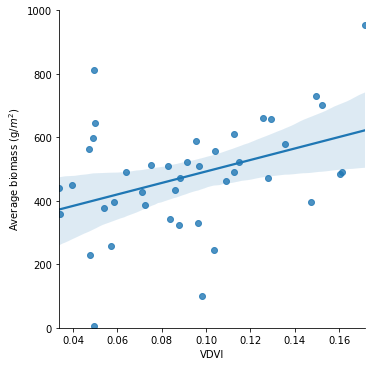

In [14]:
##Training and testing biomass ~ ndvi
result = sm.ols(formula="liveMass ~ VDVI", data = train).fit() #mass = 1809.7 * vdvi + 311.5
print(result.params)
print(result.summary())

g = sns.lmplot(x = "VDVI", y = "liveMass", ci = 95, data=train) ##CI seems a little too small?
g.set_axis_labels("VDVI", "Average biomass (g/$m^2$)")
g.set(ylim=(0, None))

<ipython-input-15-0bed1b206d24>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = 1809.7 * test['VDVI'] + 311.5


143.59124863978522

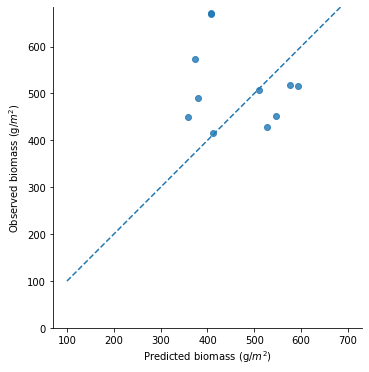

In [15]:
##plot observed vs predicted
test['predicted'] = 1809.7 * test['VDVI'] + 311.5
x = sns.lmplot(x = "liveMass", y = "predicted", fit_reg=False, data=test)
x.set_axis_labels("Predicted biomass (g/$m^2$)", "Observed biomass (g/$m^2$)")
x.set(ylim=(0, None))

plt.plot([100, 700], [100, 700], '--')

##RMSE
actual = test['liveMass']
predicted = test['predicted']

mse = sklearn.metrics.mean_squared_error(actual, predicted)
sqrt(mse)

0.2769120743079044

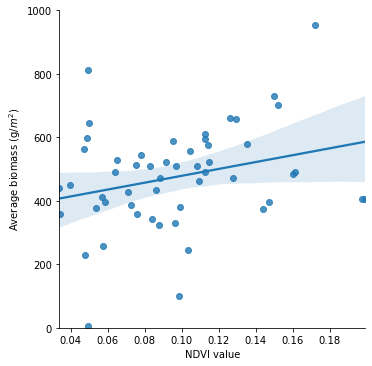

In [10]:
##Plots - all data together (no train/test)
g = sns.lmplot(x = "VDVI", y = "liveMass", ci = 95, data=masked_ndvi) ##CI seems a little too small?
g.set_axis_labels("NDVI value", "Average biomass (g/$m^2$)")
g.set(ylim=(0, None))

masked_ndvi['VDVI'].corr(masked_ndvi['liveMass'], method = 'pearson')

#my_path = os.path.abspath('/Users/asariversjulien/Documents/Georgia/Project')
#my_file = 'p1.png'
#g.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')

##FLOODED PLOTS. something to consider with image collection that you have
##Error bars???

In [35]:
result = sm.ols(formula="liveMass ~ VDVI", data = masked_ndvi).fit()
print(result.params)
print(result.summary())

Intercept     370.539827
VDVI         1082.992397
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               liveMass   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     4.235
Date:                Tue, 04 May 2021   Prob (F-statistic):             0.0447
Time:                        13:04:47   Log-Likelihood:                -341.86
No. Observations:                  53   AIC:                             687.7
Df Residuals:                      51   BIC:                             691.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

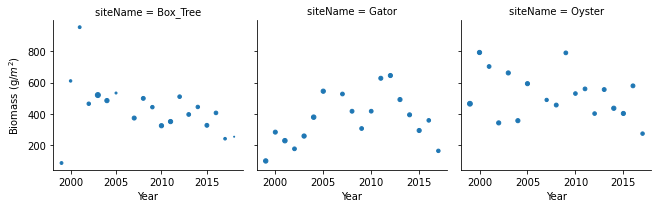

In [28]:
site_list = ['Box_Tree', 'Gator', 'Oyster']
df2 = mn_siteyears[mn_siteyears['siteName'].isin(site_list)]
g = sns.FacetGrid(df2, col="siteName", col_wrap=4,  sharex=False)
#g = sns.FacetGrid(masked_ndvi[masked_ndvi['siteName'] == 'Box_Tree'], col="siteName",  sharex=False)
g = g.map(plt.scatter, 'EOYBYear', 'liveMass') ##interesting patterns here!!
g.set_axis_labels("Year", "Biomass (g/$m^2$)")
##Boxtree/Cushmans/Hog/Oyster = steady decrease in biomass over time
##Gator cyclical. Steelmans the only site that increased, but low N

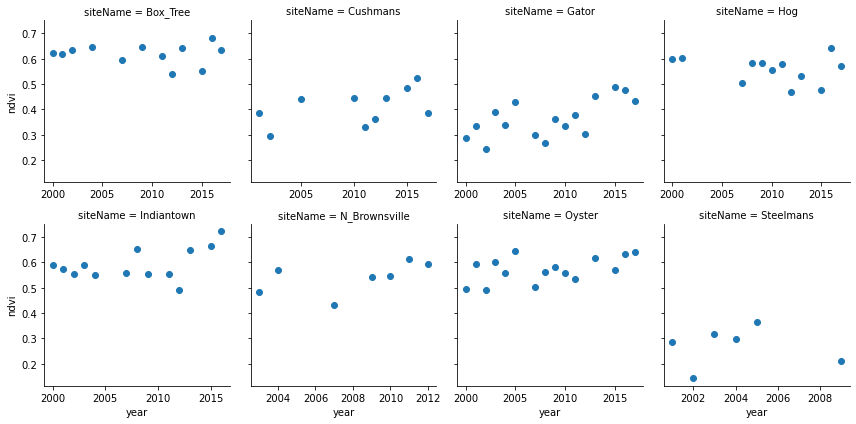

In [69]:
x_x = sns.FacetGrid(df2, col="siteName", col_wrap=4,  sharex=False)
g_x = x_x.map(plt.scatter, 'year', 'ndvi')

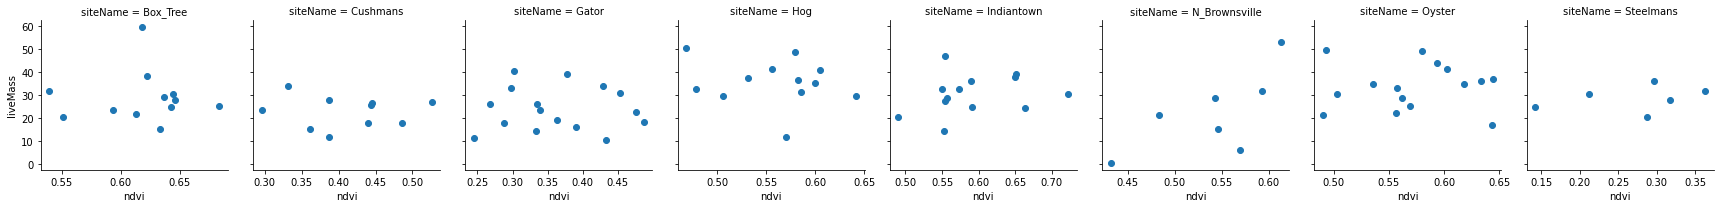

In [15]:
y_y = sns.FacetGrid(df2, col="siteName",  sharex=False) ##the way I'm doing things, ndvi bad predictor!!
g_y = y_y.map(plt.scatter, 'ndvi', 'liveMass')

In [26]:
print("hi")

hi
